## Import libraries

In [7]:
# Import libraries
from ml4fgnetworks.models.networks import ExpressionEvoRateDataset
from ml4fgnetworks.models.networks import Net2
from ml4fgnetworks.models.networks import net_rnn
from ml4fgnetworks.models.networks import train_neural_network
from ml4fgnetworks.models.networks import plot_model_predictions
import pandas as pd
import numpy as np
import torch
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error
from captum.attr import IntegratedGradients


## Load and process data

In [8]:
# Load Data
data = pd.read_csv('Human_Expression_EvoRates.txt', sep = '\t')

# Eliminate null data
data = data.loc[~data['Ka_Mouse'].isnull()]

# Tissues
tissues = data.drop(columns=['id', 'id_symbol', 'Ka_Mouse']).columns

# Prepare data
X = np.array(np.log10(data.drop(columns=['id', 'id_symbol', 'Ka_Mouse'])+1e-4))
X = torch.tensor(X).float()
y = np.array(np.log10(data['Ka_Mouse'].values))
y = torch.tensor(y).float()

# Normalize data
X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
y = (y - y.mean()) / y.std()

# Permute the data indexes
np.random.seed(12) # for reproducibility
rand_perm = np.random.permutation(len(y))

# Define training, validation, and test indexes
train_idx = rand_perm[:int(np.ceil(0.8 * len(y)))]
val_idx = rand_perm[int(np.ceil(0.8 * len(y))):int(np.ceil(0.9 * len(y)))]
test_idx = rand_perm[int(np.ceil(0.9 * len(y))):]

# Split data into training, validation and testing
X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

# Creat dataloaders
train_dataset = ExpressionEvoRateDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)

validation_dataset = ExpressionEvoRateDataset(X_val, y_val)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100)

test_dataset = ExpressionEvoRateDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

## Train dense neural network

In [9]:
# Define network
my_dnn = Net2([X.shape[1], 64, 32, 16, 1], dropout=0.1)
optimizer = torch.optim.Adam(my_dnn.parameters(), amsgrad=True)
my_dnn, train_mse, val_mse = train_neural_network(my_dnn, train_dataloader, validation_dataloader, optimizer, 300, 300)

Epoch 1 took 0.21s. Train loss: 0.8083. Val loss: 0.7724. Patience left: 200
Epoch 2 took 0.17s. Train loss: 0.7851. Val loss: 0.7627. Patience left: 200
Epoch 3 took 0.17s. Train loss: 0.7755. Val loss: 0.7550. Patience left: 200
Epoch 4 took 0.17s. Train loss: 0.7649. Val loss: 0.7454. Patience left: 200
Epoch 5 took 0.17s. Train loss: 0.7598. Val loss: 0.7453. Patience left: 200
Epoch 6 took 0.17s. Train loss: 0.7570. Val loss: 0.7366. Patience left: 200
Epoch 7 took 0.17s. Train loss: 0.7528. Val loss: 0.7321. Patience left: 200
Epoch 8 took 0.17s. Train loss: 0.7490. Val loss: 0.7293. Patience left: 200
Epoch 9 took 0.17s. Train loss: 0.7429. Val loss: 0.7331. Patience left: 199
Epoch 10 took 0.17s. Train loss: 0.7411. Val loss: 0.7171. Patience left: 200
Epoch 11 took 0.17s. Train loss: 0.7362. Val loss: 0.7220. Patience left: 199
Epoch 12 took 0.17s. Train loss: 0.7327. Val loss: 0.7170. Patience left: 200
Epoch 13 took 0.17s. Train loss: 0.7328. Val loss: 0.7178. Patience left:

## Plot training and validation RMSE

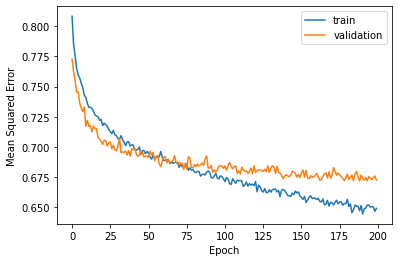

In [10]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(train_mse, label = 'train')
plt.plot(val_mse, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('./figures/dnn_training.png')

## Plot predicted and fitted evolutionary rates

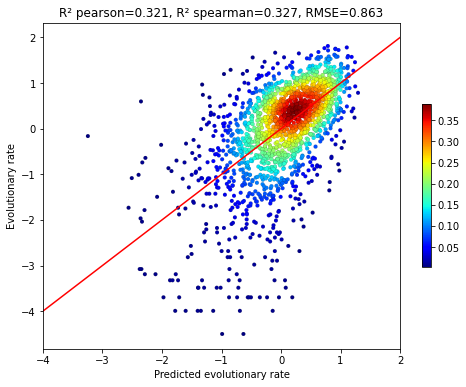

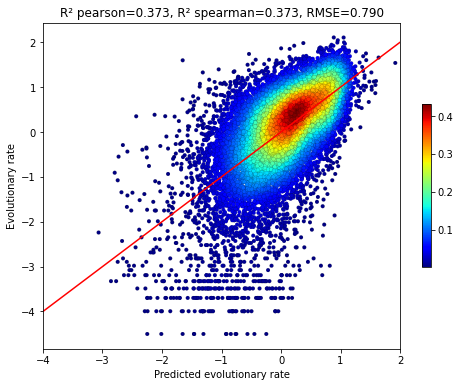

In [11]:
# Prediction
pred_loss = my_dnn(X_test)
pred_loss = pred_loss.squeeze()
plot_model_predictions(pred_loss, y_test, xlims=[-4,2])
plt.savefig('./figures/dnn_prediction.png')

# Fitting
fit_loss = my_dnn(X_train)
fit_loss = fit_loss.squeeze()
plot_model_predictions(fit_loss, y_train, xlims=[-4,2])
plt.savefig('./figures/dnn_fitting.png')

## Train after adding a recurrent layer

In [3]:
# Define network
my_rnn_dnn = net_rnn(1, 53, [64, 32, 16, 1], dropout=0.1)
optimizer = torch.optim.Adam(my_rnn_dnn.parameters(), amsgrad=True)
my_rnn_dnn, train_mse, val_mse = train_neural_network(my_rnn_dnn, train_dataloader, validation_dataloader, optimizer, 300, 300)

Epoch 1 took 0.51s. Train loss: 0.9094. Val loss: 0.7973. Patience left: 300
Epoch 2 took 0.51s. Train loss: 0.7862. Val loss: 0.7409. Patience left: 300
Epoch 3 took 0.50s. Train loss: 0.7705. Val loss: 0.7346. Patience left: 300
Epoch 4 took 0.52s. Train loss: 0.7649. Val loss: 0.7284. Patience left: 300
Epoch 5 took 0.51s. Train loss: 0.7587. Val loss: 0.7260. Patience left: 300
Epoch 6 took 0.50s. Train loss: 0.7561. Val loss: 0.7201. Patience left: 300
Epoch 7 took 0.50s. Train loss: 0.7472. Val loss: 0.7129. Patience left: 300
Epoch 8 took 0.50s. Train loss: 0.7410. Val loss: 0.7090. Patience left: 300
Epoch 9 took 0.50s. Train loss: 0.7347. Val loss: 0.7014. Patience left: 300
Epoch 10 took 0.51s. Train loss: 0.7343. Val loss: 0.7011. Patience left: 300
Epoch 11 took 0.51s. Train loss: 0.7311. Val loss: 0.6993. Patience left: 300
Epoch 12 took 0.51s. Train loss: 0.7267. Val loss: 0.6962. Patience left: 300
Epoch 13 took 0.50s. Train loss: 0.7213. Val loss: 0.6935. Patience left:

## Plot training and validation RMSE

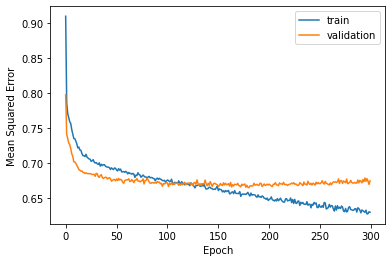

In [6]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(train_mse, label = 'train')
plt.plot(val_mse, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('./figures/rnn_training.png')

## Plot predicted and fitted evolutionary rates

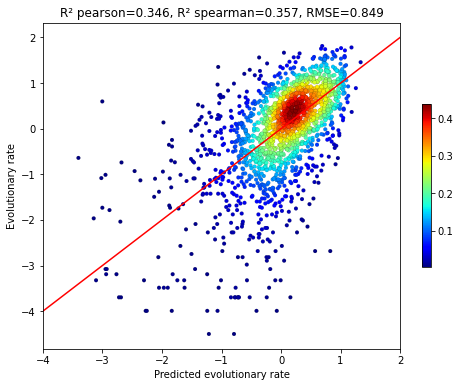

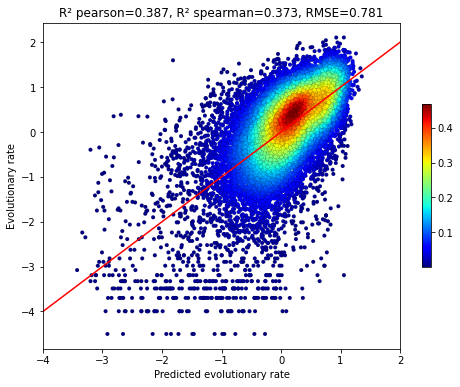

In [5]:
# Prediction
pred_loss = my_rnn_dnn(X_test)
pred_loss = pred_loss.squeeze()
plot_model_predictions(pred_loss, y_test, xlims=[-4,2])
plt.savefig('./figures/rnn_prediction.png')

# Fitting
fit_loss = my_rnn_dnn(X_train)
fit_loss = fit_loss.squeeze()
plot_model_predictions(fit_loss, y_train, xlims=[-4,2])
plt.savefig('./figures/rnn_fitting.png')

## Calculate integrated gradients

In [9]:
# Get attributions
my_rnn_dnn.eval()
ig = IntegratedGradients(my_rnn_dnn)
X.requires_grad_()
attr, delta = ig.attribute(X, target=0, return_convergence_delta=True)
attr = attr.detach().numpy()

# Visualize importances
ig_importances = pd.DataFrame({'tissues':tissues, 'importances':np.mean(attr, axis=0)})
ig_importances.sort_values(by=['importances'], ascending=True)

,tissues,importances
13,Brain - Frontal Cortex (BA9),-0.817108
5,Artery - Tibial,-0.332113
50,Uterus,-0.299823
35,Lung,-0.245322
28,Esophagus - Mucosa,-0.239602
16,Brain - Nucleus accumbens (basal ganglia),-0.200987
7,Brain - Amygdala,-0.181077
22,Cells - Transformed fibroblasts,-0.176827
8,Brain - Anterior cingulate cortex (BA24),-0.158210
23,Cervix - Ectocervix,-0.157672


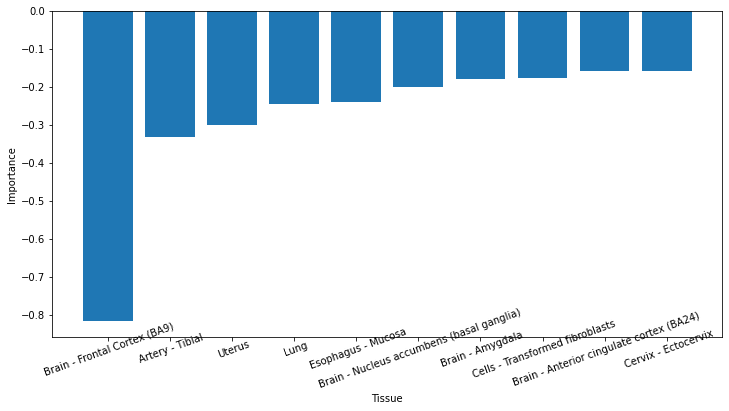

In [34]:
# Bar plot
x_pos = (np.arange(len(tissues)))
importances = np.mean(attr, axis=0)
indices = np.argsort(importances)
plt.figure(figsize=(12,6))
plt.bar(x_pos[0:10], importances[indices[0:10]], align='center')
plt.xticks(x_pos[0:10], tissues[indices[0:10]], wrap=True)
plt.xlabel('Tissue')
plt.ylabel('Importance')
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 20)
plt.savefig('./figures/integrated_gradients.png')